# Main imports

## Native imports

In [4]:
import os
import pandas as pd
from datetime import date, datetime
from random import choice, randint

## More imports

In [5]:
import matplotlib.pyplot as plt

import numpy as np

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras

from keras import Model, layers, metrics, optimizers

from keras.applications import resnet

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D, BatchNormalization, Layer

from keras.regularizers import l2
 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Own imports

In [6]:
from data_explorer import get_celebrities, show_gb, gbdf_to_list

## Process data

Amb aquestes funcions l'objectiu es obtenir les dades de les imatges a partir de donar-li el nom/ruta complerta de les imatges

In [7]:
def preprocess_image(img_name):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    filename = img_dir +img_name
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, img_size)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

# Load imatge classification

In [8]:
identity_df, rest = get_celebrities(20)
print(identity_df["Identity"].nunique())
identity_df

20


,Image_name,Identity
0,000096.jpg,4262
1,000116.jpg,4887
2,000150.jpg,6568
3,000838.jpg,4887
4,001553.jpg,2820
...,...,...
633,200678.jpg,9256
634,200853.jpg,9256
635,201865.jpg,9256
636,201873.jpg,9256


Ordeno el datafram i creo un group_by a partir de les persones

In [9]:
identity_df_gb_iden = identity_df.sort_values(["Identity", "Image_name"]).groupby("Identity")
show_gb(identity_df_gb_iden, n_gb=3, num_groups=3)

    Image_name  Identity
5   001786.jpg      1757
25  009205.jpg      1757
29  010068.jpg      1757 

    Image_name  Identity
35  011511.jpg      2070
37  011753.jpg      2070
68  020507.jpg      2070 

    Image_name  Identity
9   002601.jpg      2114
26  009241.jpg      2114
53  015218.jpg      2114 



Mostrem quantes imatges hi ha per persona

In [10]:
identity_df_gb_iden.count()

,Image_name
Identity,
1757,31
2070,30
2114,31
2820,35
3227,35
3699,34
3745,34
3782,35
4126,31


In [11]:
d = identity_df_gb_iden.count()
d = d.reset_index()
d["Identity"]

0      1757
1      2070
2      2114
3      2820
4      3227
5      3699
6      3745
7      3782
8      4126
9      4262
10     4740
11     4887
12     4978
13     6568
14     8968
15     9152
16     9256
17     9840
18     9915
19    10083
Name: Identity, dtype: int64

In [12]:
identity_df.index

RangeIndex(start=0, stop=638, step=1)

In [13]:
print(identity_df["Identity"][0])
d.iloc[identity_df["Identity"][0]]

4262


IndexError: single positional indexer is out-of-bounds

## Get anchor, pos and neg list imatge

In [ ]:
img_dir = "Imatges/CelebA/Img/img_align_celeba/img_align_celeba/"
img_size = (178,218)

### Anchor and positive list and datasets

In [ ]:
anchor_images = gbdf_to_list(identity_df_gb_iden, "Image_name")
positive_images = gbdf_to_list(identity_df_gb_iden, "Image_name", sort=True)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

### Negative list and dataset

In [ ]:
index = randint(0, rest.shape[0] - identity_df.shape[0])
neg_df = rest.iloc[index:index+identity_df.shape[0]]
negative_images = list(neg_df["Image_name"])

np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

Let's setup our data pipeline using a zipped list with an anchor, positive,
and negative image filename as the source. The output of the pipeline
contains the same triplet with every image loaded and preprocessed.

En el meu cas donare al anchor les imatges ordenades per persona. Al positive donare el mateix ordre de persones que en el anchor pero barrejant les imatges per cada persona per a que un triplet tingui dos fotos diferents de la mateixa persona i una foto d'un altre persona

In [ ]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 178, 218, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 178, 218, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 178, 218, 3), dtype=tf.float32, name=None))>

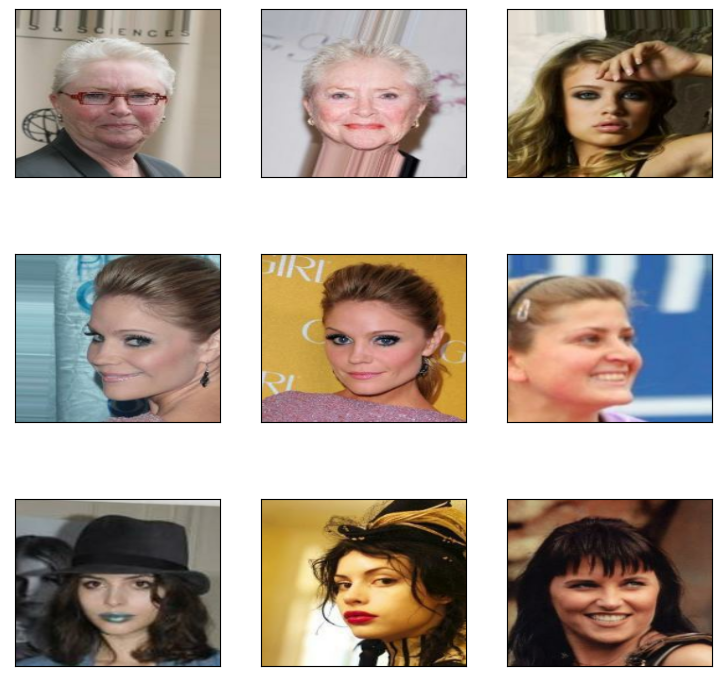

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Setting up the embedding generator model

Our Siamese Network will generate embeddings for each of the images of the
triplet. To do this, we will use a ResNet50 model pretrained on ImageNet and
connect a few `Dense` layers to it so we can learn to separate these
embeddings.

We will freeze the weights of all the layers of the model up until the layer `conv5_block1_out`.
This is important to avoid affecting the weights that the model has already learned.
We are going to leave the bottom few layers trainable, so that we can fine-tune their weights
during training.

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=img_size + (3,), include_top=False
)

flatten = Flatten()(base_cnn.output) # converteix convo en un vector
dense1 = Dense(512, activation="relu")(flatten)
dense1 = BatchNormalization()(dense1)
dense2 = Dense(256, activation="relu")(dense1)
dense2 = BatchNormalization()(dense2)
output = Dense(256)(dense2)
# Aquesta sortide de 256 es el embeding (vector de 256)
# apendre la representacio de la imatge

embedding = keras.Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

## Setting up the Siamese Network model

The Siamese network will receive each of the triplet images as an input,
generate the embeddings, and output the distance between the anchor and the
positive embedding, as well as the distance between the anchor and the negative
embedding.

To compute the distance, we can use a custom layer `DistanceLayer` that
returns both values as a tuple.

In [ ]:

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=img_size + (3,))
positive_input = layers.Input(name="positive", shape=img_size + (3,))
negative_input = layers.Input(name="negative", shape=img_size + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

## Putting everything together

We now need to implement a model with custom training loop so we can compute
the triplet loss using the three embeddings produced by the Siamese network.

Let's create a `Mean` metric instance to track the loss of the training process.

In [ ]:

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


## Training

We are now ready to train our model.

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(loss='mse', optimizer=optimizers.Adam(0.0001), metrics=['mae'])
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
16/16 [==============================] - 147s 9s/step - loss: 0.5549 - val_loss: 0.4398
Epoch 2/10
16/16 [==============================] - 135s 8s/step - loss: 0.4308 - val_loss: 0.3147
Epoch 3/10
16/16 [==============================] - 132s 8s/step - loss: 0.3508 - val_loss: 0.2787
Epoch 4/10
16/16 [==============================] - 128s 8s/step - loss: 0.2612 - val_loss: 0.2613
Epoch 5/10
16/16 [==============================] - 129s 8s/step - loss: 0.2276 - val_loss: 0.2430
Epoch 6/10
16/16 [==============================] - 128s 8s/step - loss: 0.2262 - val_loss: 0.1629
Epoch 7/10
16/16 [==============================] - 129s 8s/step - loss: 0.1863 - val_loss: 0.1559
Epoch 8/10
16/16 [==============================] - 128s 8s/step - loss: 0.1751 - val_loss: 0.1817
Epoch 9/10
16/16 [==============================] - 129s 8s/step - loss: 0.1704 - val_loss: 0.1566
Epoch 10/10
16/16 [==============================] - 130s 8s/step - loss: 0.1907 - val_loss: 0.1301


## Inspecting what the network has learned

At this point, we can check how the network learned to separate the embeddings
depending on whether they belong to similar images.

We can use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to measure the
similarity between embeddings.

Let's pick a sample from the dataset to check the similarity between the
embeddings generated for each image.

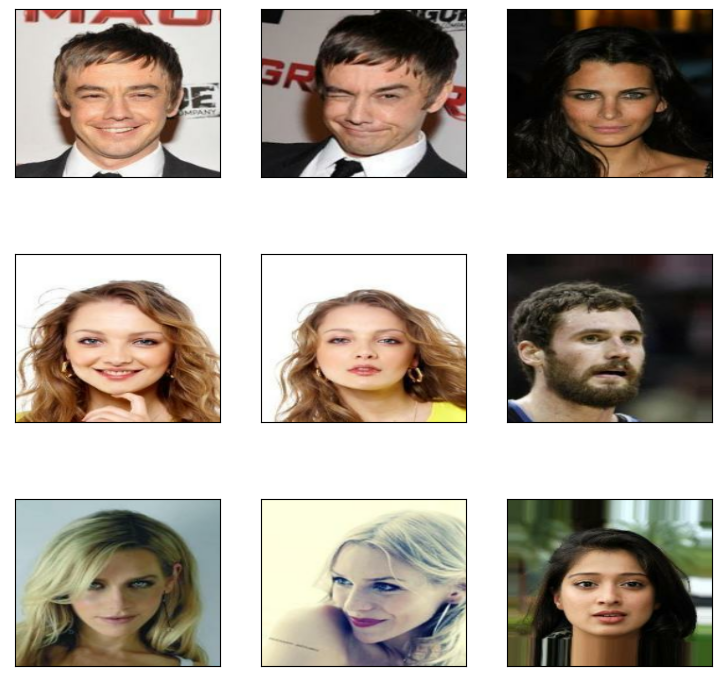

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

Finally, we can compute the cosine similarity between the anchor and positive
images and compare it with the similarity between the anchor and the negative
images.

We should expect the similarity between the anchor and positive images to be
larger than the similarity between the anchor and the negative images.

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.9990181
Negative similarity 0.99842656
